In [1]:
import networkx as nx
import matplotlib.pyplot as plt


c:\Users\sgupta1\AppData\Local\Programs\Python\Python311\Lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


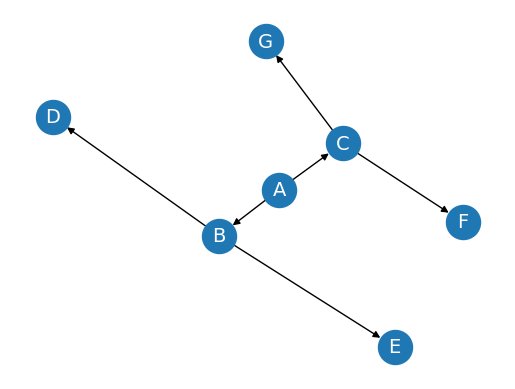

In [3]:
G = nx.DiGraph()
G.add_edges_from([('A', 'B'), ('A', 'C'), ('B', 'D'), ('B', 'E'), ('C', 'F'), ('C', 'G')])

plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_size=600,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )

In [4]:
from torch_geometric.datasets import WikipediaNetwork
import torch_geometric.transforms as T
dataset = WikipediaNetwork(root=".", name="chameleon",
transform = T.RandomNodeSplit(num_val=200, num_test=500))
data = dataset[0]

Processing...
Done!


Data(x=[2277, 2325], edge_index=[2, 36101], y=[2277], train_mask=[2277], val_mask=[2277], test_mask=[2277])

In [8]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-geometric-temporal==0.54.0

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEPRECATION: pygeostat 1.1.1 has a non-standard dependency specifier matplotlib>=2.2.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pygeostat or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
  error: subprocess-exited-with-error
  
  × Building wheel for pandas (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [2474 lines of output]
      <string>:19: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-311
      creating build\lib.win-amd64-cpython-311\pandas
      copying pandas\conftest.py -> build\lib.win-amd64-cpython-311\pandas
      copying pandas\testing.py -> build\lib.win-amd64-cpython-3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("book1.csv")

In [3]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  
    return c * r

In [4]:
target_lat = 36.626065
target_lon =-87.606475

In [5]:
distances = df.apply(lambda row: haversine(target_lat, target_lon, row['GPS Latitude'], row['GPS Longitude']), axis=1)

In [6]:
distances

0    142.934824
1    145.139182
2    147.213521
3    145.916557
4    160.156672
dtype: float64

In [7]:
def compute_adj(distances, sigma2=1, epsilon=0.5):
    d = distances.to_numpy()
    d2 = d * d
    n = distances.shape[0]  
    w_mask = np.ones([n, n]) - np.identity(n)
    return (d2 / sigma2) * ((d2 / sigma2) >= epsilon) * w_mask

adj = compute_adj(distances)

In [8]:
adj

array([[    0.        , 21065.38213475, 21671.82069377, 21291.64149272,
        25650.15948332],
       [20430.36405052,     0.        , 21671.82069377, 21291.64149272,
        25650.15948332],
       [20430.36405052, 21065.38213475,     0.        , 21291.64149272,
        25650.15948332],
       [20430.36405052, 21065.38213475, 21671.82069377,     0.        ,
        25650.15948332],
       [20430.36405052, 21065.38213475, 21671.82069377, 21291.64149272,
            0.        ]])

Text(0, 0.5, 'Sensor station')

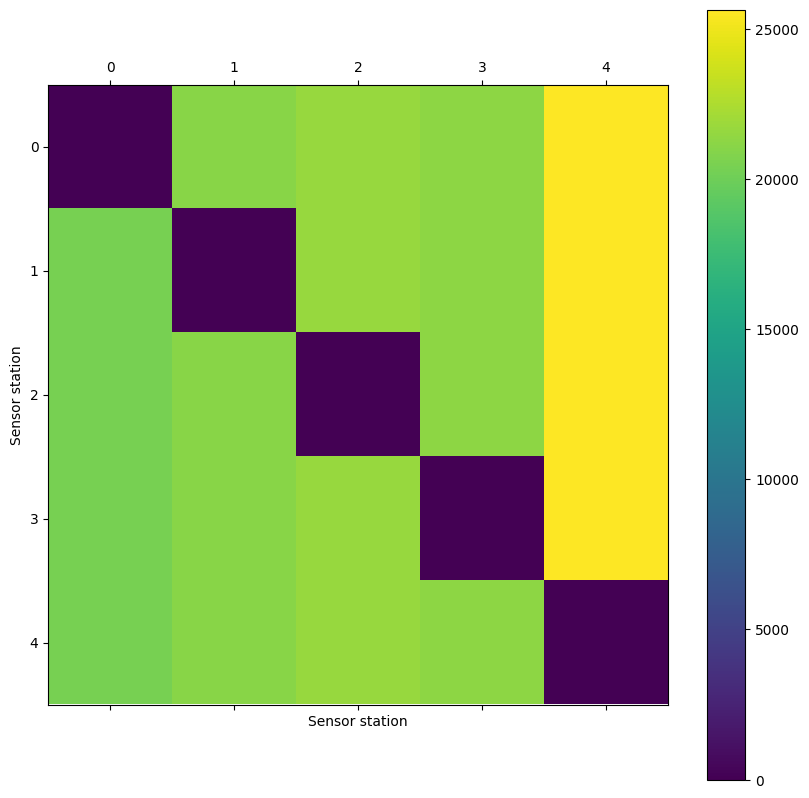

In [9]:
plt.figure(figsize=(10, 10))
cax = plt.matshow(adj, False)
plt.colorbar(cax)
plt.xlabel("Sensor station")
plt.ylabel("Sensor station")

[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4] [1 2 3 4 0 2 3 4 0 1 3 4 0 1 2 4 0 1 2 3] <zip object at 0x0000015A79876840>


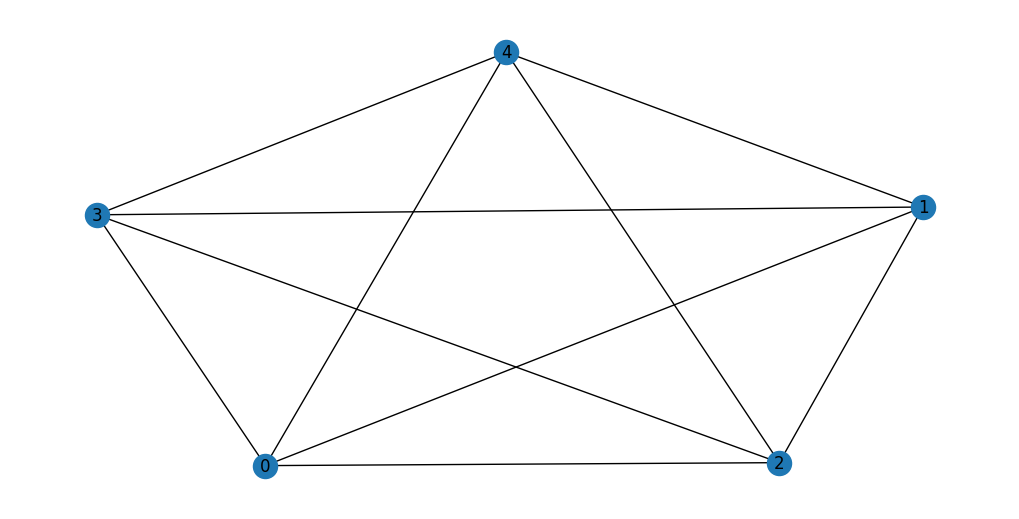

In [28]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_graph(adj):
    plt.figure(figsize=(10,5))
    rows, cols = np.where(adj > 0)
    edges = zip(rows.tolist(), cols.tolist())
    G = nx.Graph()
    G.add_edges_from(edges)
    nx.draw(G, with_labels=True)
    print(rows,cols,edges)
    plt.show()

plot_graph(adj)

In [20]:
aadt=df['AADT'].to_numpy()

In [11]:
import folium

# Create a base map
m = folium.Map(location=[df['GPS Latitude'].mean(), df['GPS Longitude'].mean()], zoom_start=5)

# Add circle markers
for index, row in df.iterrows():
    folium.CircleMarker(
        location=[row['GPS Latitude'], row['GPS Longitude']],
        radius=row['AADT']/1000,  # Adjust the radius as needed
        popup=folium.Popup(f"""<strong>Adminstrative system:</strong> {row['Adm. Sys.']} 
                                    <strong> Government County</strong> {row['Gov. Cont.']}
                                    <br><strong>Coordinates:</strong> {row['GPS Latitude']}, {row['GPS Longitude']}
                                    <br><strong>AADT:</strong> {row['AADT']} """, max_width=450),
        fill=True
    ).add_to(m)

# Display the map
m

In [26]:
print(f"Degree centrality = {nx.degree_centrality(G)}")
print(f"Closeness centrality = {nx.closeness_centrality(G)}")
print(f"Betweenness centrality = {nx.betweenness_centrality(G)}")

Degree centrality = {35.626065: 0.1111111111111111, -86.606475: 0.1111111111111111, 35.61036: 0.1111111111111111, -86.591587: 0.1111111111111111, 35.599442: 0.1111111111111111, -86.571658: 0.1111111111111111, 35.643684: 0.1111111111111111, -86.529174: 0.1111111111111111, 35.601669: 0.1111111111111111, -86.353099: 0.1111111111111111}
Closeness centrality = {35.626065: 0.0, -86.606475: 0.1111111111111111, 35.61036: 0.0, -86.591587: 0.1111111111111111, 35.599442: 0.0, -86.571658: 0.1111111111111111, 35.643684: 0.0, -86.529174: 0.1111111111111111, 35.601669: 0.0, -86.353099: 0.1111111111111111}
Betweenness centrality = {35.626065: 0.0, -86.606475: 0.0, 35.61036: 0.0, -86.591587: 0.0, 35.599442: 0.0, -86.571658: 0.0, 35.643684: 0.0, -86.529174: 0.0, 35.601669: 0.0, -86.353099: 0.0}


In [ ]:
import networkx as nx

# Placeholder data structure for the nodes and their attributes
node_data = [
    {'id': 1, 'lat': 40.7128, 'lon': -74.0060, 'aadt': 10000, 'speed_limit': 30, 'admin_system': 'A'},
    {'id': 2, 'lat': 34.0522, 'lon': -118.2437, 'aadt': 15000, 'speed_limit': 35, 'admin_system': 'B'},
    {'id': 3, 'lat': 41.8781, 'lon': -87.6298, 'aadt': 12000, 'speed_limit': 25, 'admin_system': 'A'},
]

# Creating a graph
G = nx.Graph()

# Adding nodes and attributes to the graph
for node in node_data:
    G.add_node(node['id'], lat=node['lat'], lon=node['lon'], aadt=node['aadt'], speed_limit=node['speed_limit'], admin_system=node['admin_system'])

# Adding edges between all pairs of nodes (for demonstration purposes)
for node1 in node_data:
    for node2 in node_data:
        if node1['id'] != node2['id']:
            G.add_edge(node1['id'], node2['id'], weight=1)

# Function to predict AADT based on neighboring nodes
def predict_aadt(graph, target_node_id):
    """
    Predict the AADT for a target node based on the average AADT of its neighbors.

    :param graph: The graph object containing the nodes and edges.
    :param target_node_id: The ID of the node for which to predict the AADT.
    :return: The predicted AADT value.
    """
    neighbors = list(graph.neighbors(target_node_id))
    if not neighbors:
        raise ValueError(f"No neighbors found for node {target_node_id}. Cannot predict AADT.")
    
    # Calculate the average AADT of neighboring nodes
    avg_aadt = sum(graph.nodes[neighbor]['aadt'] for neighbor in neighbors) / len(neighbors)
    return avg_aadt

# Example of predicting AADT for node 1
# predict_aadt(G, 1)  # Uncomment to test in an appropriate environment

